In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math, re, os

print(tf.__version__)

2022-06-11 05:51:11.561557: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-11 05:51:11.561646: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.4.1


Reference for importing data: https://www.kaggle.com/code/ryanholbrook/create-your-first-submission/notebook

In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-06-11 05:51:14.604904: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-11 05:51:14.605321: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-06-11 05:51:14.605345: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-11 05:51:14.605378: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f6aecf50a61d): /proc/driver/nvidia/version does not exist
2022-06-11 05:51:14.606335: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [3]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

gs://kds-5c3121c5ef866d04eea12fc8ede2e218d27408e1fedc26fd9d61fee1


In [4]:
IMAGE_SIZE = [192, 192]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-192x192'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

2022-06-11 05:51:21.827634: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-06-11 05:51:21.904377: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-06-11 05:51:21.979680: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [5]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [7]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_training_dataset_preview(ordered=False):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [8]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print('Batch Size: ', BATCH_SIZE)

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Batch Size:  128
Training: <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.string)>


In [9]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Training data label examples: [ 55  90  93 ...  14   4 103]


2022-06-11 05:51:23.700026: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 61, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654926683.696693698","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 61, Output num: 1","grpc_status":3}


In [39]:
def create_batch(ds, batch_size):
    ds_iter = iter(ds.unbatch().batch(batch_size))
    return next(ds_iter)    

def batch_to_images_labels(ds_batch):
    images, labels = ds_batch
    return images.numpy(), labels.numpy()

def batch_to_preds(images, pred_model):
    preds = pred_model.predict(images)
    preds = np.argmax(preds, axis=-1)
    return preds

def show_batch(ds, batch_size=16, pred_model=None):
    sample_batch = create_batch(ds, batch_size)
    images, labels = batch_to_images_labels(sample_batch)
    if pred_model:
        preds = batch_to_preds(images, pred_model)
    
    ncols = math.floor((math.sqrt(len(labels))))
    nrows = len(labels) // ncols
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    fig.tight_layout()
    i = 0
    for ax, image, label in zip(axs.flatten(), images, labels):
        ax.imshow(image)
        if pred_model:
            if preds[i] != label:
                ax.set_title('{} -> predicted: {} [X]'.format(CLASSES[label], CLASSES[preds[i]]), color='r')
            else:
                ax.set_title('{} [\u2713]'.format(CLASSES[preds[i]]), color='g')
            i += 1
        else:
            ax.set_title(CLASSES[label])
        ax.axis('off')

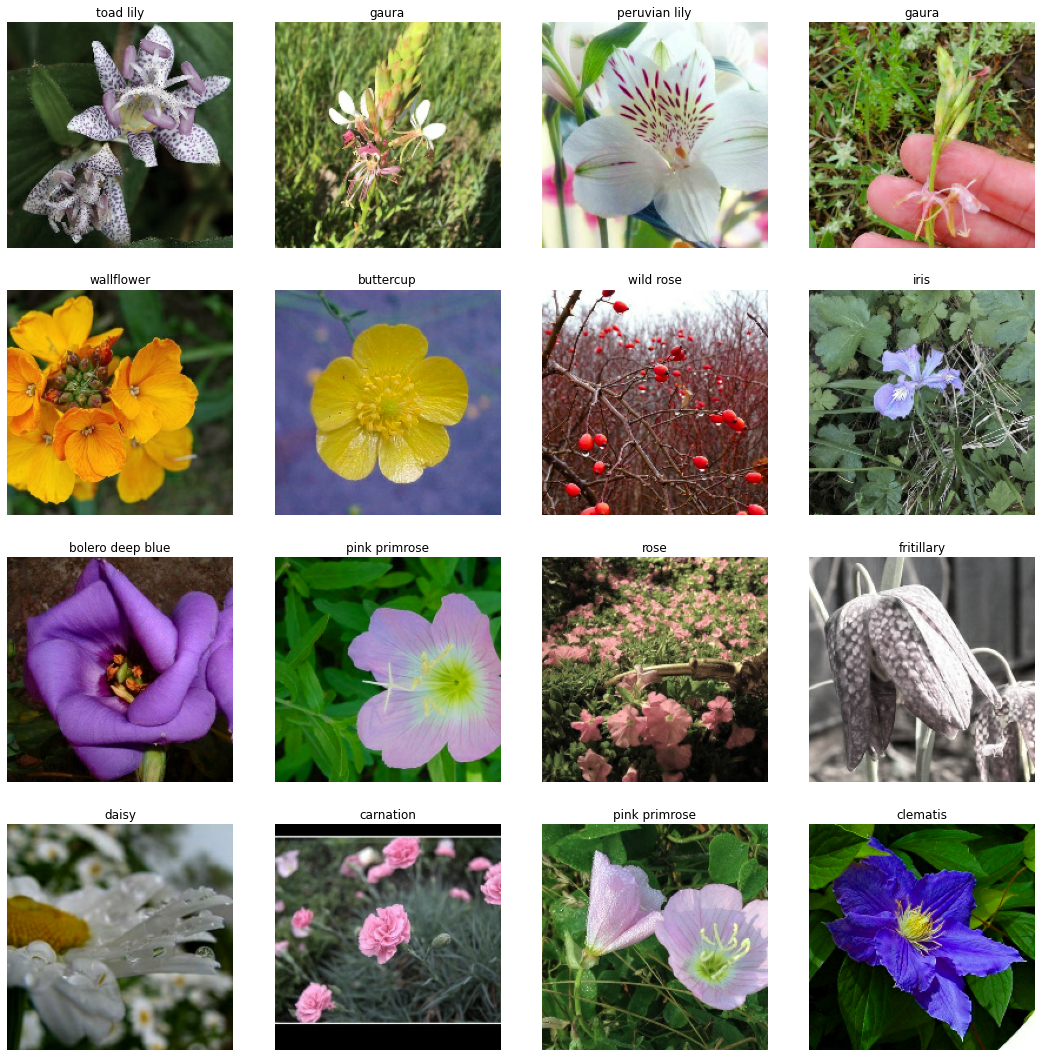

In [11]:
show_batch(ds_train)

In [12]:
def ds_to_labels(ds, num_images):
    return next(iter(ds.unbatch().map(lambda image, label: label).batch(num_images))).numpy()

def plot_class_dist(ds, num_images):
    labels = ds_to_labels(ds, num_images)
    names = map(lambda x: CLASSES[x], labels)
    names_df = pd.DataFrame(names)
    names_df.value_counts().plot.barh(figsize=(15,20))

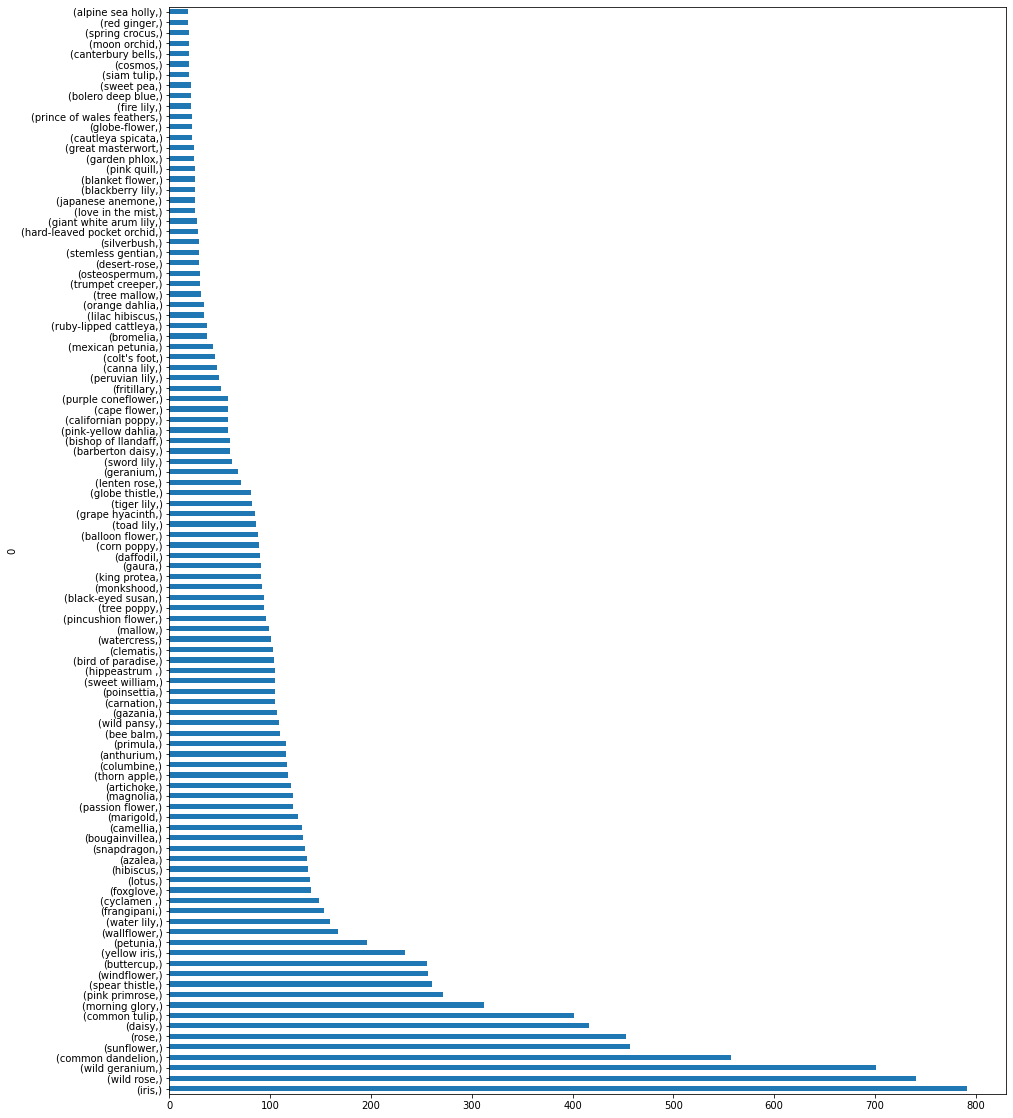

In [13]:
plot_class_dist(ds_train, NUM_TRAINING_IMAGES)

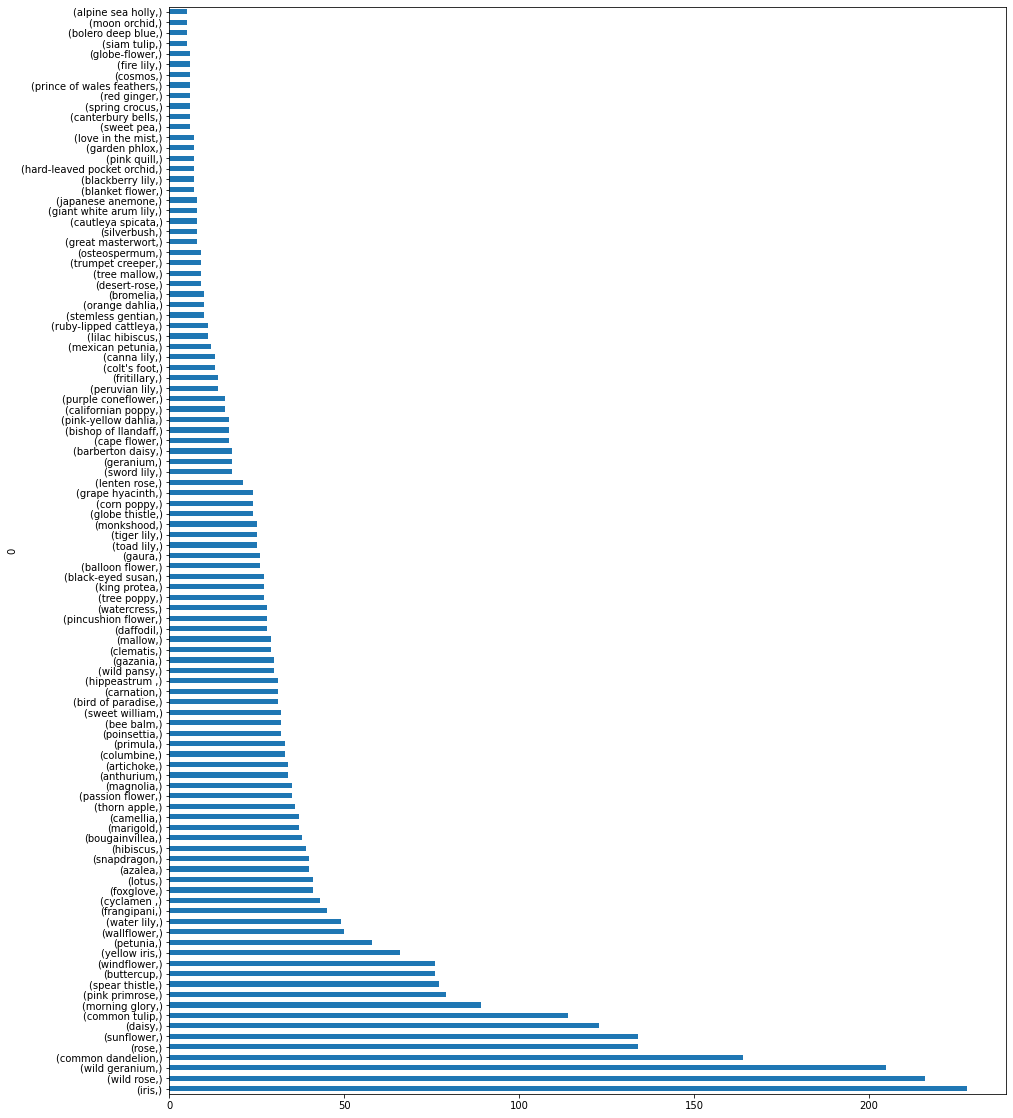

In [14]:
plot_class_dist(ds_valid, NUM_VALIDATION_IMAGES)

In [15]:
class FlowerClassifier(tf.keras.Model):
    def __init__(self, input_shape, n_classes):
        super().__init__(self)
        self.input_layer = tf.keras.layers.Conv2D(256, (3,3), activation='relu', input_shape=input_shape)
        self.conv1 = tf.keras.layers.Conv2D(128, (3,3), activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(32, (3,3), activation='relu')
        self.max_pool = tf.keras.layers.MaxPooling2D(2,2)
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(128, activation='relu')
        self.output_layer = tf.keras.layers.Dense(n_classes, activation='softmax')
        
    def call(self, input):
        x = self.input_layer(input)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)        
        x = self.output_layer(x)
        return x

In [16]:
for image, label in ds_train.take(1):
    image = image.numpy()
    BATCH_SIZE = image.shape[0]
    DIM_X = image.shape[1]
    DIM_Y = image.shape[2]
    DIM_CH = image.shape[3]

INPUT_SHAPE = [DIM_X, DIM_Y, DIM_CH]

ds_train = get_training_dataset_preview()
labels = ds_to_labels(ds_train, NUM_TRAINING_IMAGES)

N_CLASSES = len(set(labels))

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('INPUT_SHAPE: {}, N_CLASSES: {}, STEPS_PER_EPOCH: {}'.format(INPUT_SHAPE, N_CLASSES, STEPS_PER_EPOCH))

INPUT_SHAPE: [192, 192, 3], N_CLASSES: 104, STEPS_PER_EPOCH: 99


In [17]:
tf.keras.backend.clear_session()

with strategy.scope():
    model = FlowerClassifier(INPUT_SHAPE, N_CLASSES)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
EPOCHS = 35
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch/35))

history = model.fit(
    x = get_training_dataset(),
    validation_data = get_validation_dataset(),
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    callbacks=[lr_schedule]
)

Epoch 1/35
99/99 [==============================] - 18s 108ms/step - loss: 4.5172 - accuracy: 0.0379 - val_loss: 4.4031 - val_accuracy: 0.0622
Epoch 2/35
99/99 [==============================] - 7s 67ms/step - loss: 4.2499 - accuracy: 0.0644 - val_loss: 4.1884 - val_accuracy: 0.0919
Epoch 3/35
99/99 [==============================] - 7s 67ms/step - loss: 4.0753 - accuracy: 0.0886 - val_loss: 3.9887 - val_accuracy: 0.1379
Epoch 4/35
99/99 [==============================] - 7s 69ms/step - loss: 3.9255 - accuracy: 0.1073 - val_loss: 3.8940 - val_accuracy: 0.1611
Epoch 5/35
99/99 [==============================] - 7s 68ms/step - loss: 3.7785 - accuracy: 0.1321 - val_loss: 3.7447 - val_accuracy: 0.1732
Epoch 6/35
99/99 [==============================] - 7s 67ms/step - loss: 3.6831 - accuracy: 0.1386 - val_loss: 3.6711 - val_accuracy: 0.1899
Epoch 7/35
99/99 [==============================] - 7s 67ms/step - loss: 3.6115 - accuracy: 0.1500 - val_loss: 3.6628 - val_accuracy: 0.1999
Epoch 8/35


In [19]:
def plot_training_curves(history):
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    epochs = range(len(loss))
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,20))
    axs = axs.flatten()

    axs[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    axs[0].plot(epochs, acc, 'r', label='Training accuracy')
    axs[0].set_title('Accuracy')
    axs[0].legend(loc=0)

    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].set_title('Loss')
    axs[1].legend(loc=0)

    plt.show()

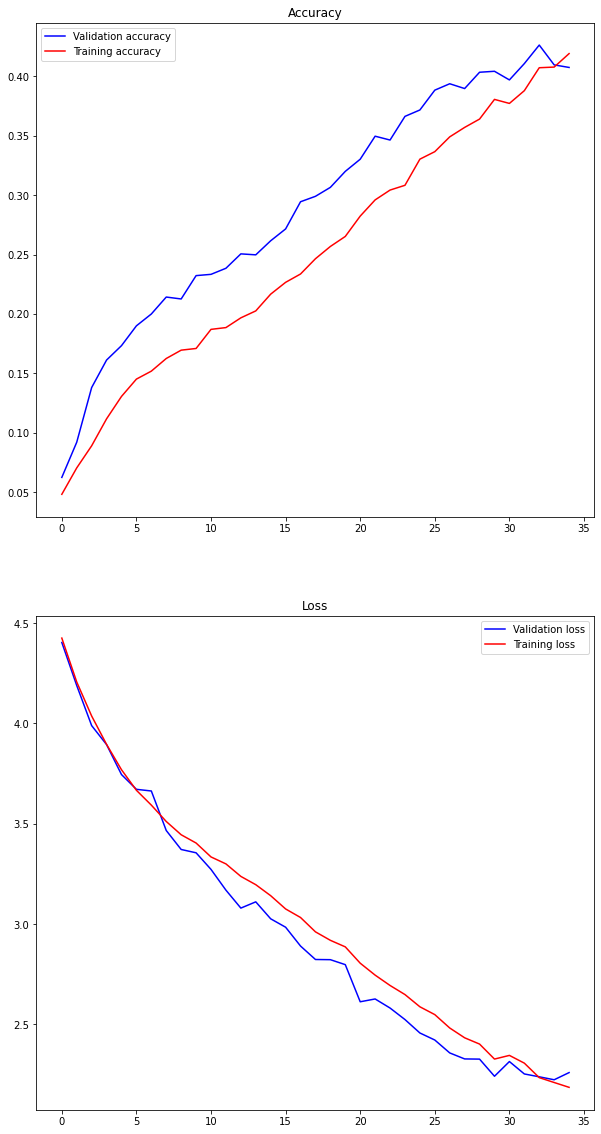

In [20]:
plot_training_curves(history)

In [23]:
tf.keras.backend.set_value(model.optimizer.learning_rate, 1e-4)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [24]:
EPOCHS = 100

history_part2 = model.fit(
    x = get_training_dataset(),
    validation_data = get_validation_dataset(),
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    callbacks=callback
)

Epoch 1/100
99/99 [==============================] - 8s 73ms/step - loss: 1.6410 - accuracy: 0.5386 - val_loss: 1.9744 - val_accuracy: 0.4787
Epoch 2/100
 2/99 [..............................] - ETA: 4s - loss: 1.6773 - accuracy: 0.5352

2022-06-11 05:58:26.909866: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 62570, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927106.909142770","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 62570, Output num: 1","grpc_status":3}


99/99 [==============================] - 7s 69ms/step - loss: 1.6493 - accuracy: 0.5380 - val_loss: 1.9525 - val_accuracy: 0.4876
Epoch 3/100
99/99 [==============================] - 7s 68ms/step - loss: 1.6311 - accuracy: 0.5432 - val_loss: 1.9512 - val_accuracy: 0.4817
Epoch 4/100
99/99 [==============================] - 7s 68ms/step - loss: 1.5944 - accuracy: 0.5479 - val_loss: 1.9580 - val_accuracy: 0.4846
Epoch 5/100
99/99 [==============================] - 7s 71ms/step - loss: 1.6019 - accuracy: 0.5496 - val_loss: 1.9450 - val_accuracy: 0.4860
Epoch 6/100
99/99 [==============================] - 7s 67ms/step - loss: 1.5966 - accuracy: 0.5472 - val_loss: 1.9379 - val_accuracy: 0.4919
Epoch 7/100
99/99 [==============================] - 7s 68ms/step - loss: 1.6032 - accuracy: 0.5518 - val_loss: 1.9439 - val_accuracy: 0.4887
Epoch 8/100
99/99 [==============================] - 7s 67ms/step - loss: 1.5552 - accuracy: 0.5582 - val_loss: 1.9478 - val_accuracy: 0.4898
Epoch 9/100
99/99 

2022-06-11 05:59:27.732568: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 72803, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927167.731721304","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 72803, Output num: 1","grpc_status":3}


99/99 [==============================] - 7s 66ms/step - loss: 1.5490 - accuracy: 0.5623 - val_loss: 1.9374 - val_accuracy: 0.4930
Epoch 12/100
99/99 [==============================] - 7s 67ms/step - loss: 1.5402 - accuracy: 0.5621 - val_loss: 1.9421 - val_accuracy: 0.4935
Epoch 13/100
99/99 [==============================] - 7s 67ms/step - loss: 1.5348 - accuracy: 0.5638 - val_loss: 1.9348 - val_accuracy: 0.4927
Epoch 14/100
99/99 [==============================] - 7s 66ms/step - loss: 1.5302 - accuracy: 0.5651 - val_loss: 1.9366 - val_accuracy: 0.4930
Epoch 15/100
99/99 [==============================] - 7s 66ms/step - loss: 1.4905 - accuracy: 0.5780 - val_loss: 1.9365 - val_accuracy: 0.4965
Epoch 16/100
99/99 [==============================] - 7s 73ms/step - loss: 1.5079 - accuracy: 0.5661 - val_loss: 1.9322 - val_accuracy: 0.4949
Epoch 17/100
99/99 [==============================] - 7s 67ms/step - loss: 1.4958 - accuracy: 0.5715 - val_loss: 1.9289 - val_accuracy: 0.4978
Epoch 18/100

2022-06-11 06:00:28.236306: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 83036, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927228.236071848","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 83036, Output num: 1","grpc_status":3}


99/99 [==============================] - 7s 67ms/step - loss: 1.4847 - accuracy: 0.5764 - val_loss: 1.9392 - val_accuracy: 0.4941
Epoch 21/100
99/99 [==============================] - 7s 68ms/step - loss: 1.4598 - accuracy: 0.5784 - val_loss: 1.9389 - val_accuracy: 0.4965
Epoch 22/100
99/99 [==============================] - 7s 68ms/step - loss: 1.4866 - accuracy: 0.5777 - val_loss: 1.9410 - val_accuracy: 0.4906
Epoch 23/100
99/99 [==============================] - 7s 67ms/step - loss: 1.4644 - accuracy: 0.5828 - val_loss: 1.9155 - val_accuracy: 0.5016
Epoch 24/100
99/99 [==============================] - 7s 74ms/step - loss: 1.4402 - accuracy: 0.5872 - val_loss: 1.9353 - val_accuracy: 0.4987
Epoch 25/100
99/99 [==============================] - 7s 68ms/step - loss: 1.4561 - accuracy: 0.5797 - val_loss: 1.9291 - val_accuracy: 0.4930
Epoch 26/100
99/99 [==============================] - 7s 67ms/step - loss: 1.4192 - accuracy: 0.5939 - val_loss: 1.9313 - val_accuracy: 0.4984
Epoch 27/100

2022-06-11 06:01:29.555103: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 93269, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927289.554721671","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 93269, Output num: 0","grpc_status":3}


99/99 [==============================] - 7s 68ms/step - loss: 1.4083 - accuracy: 0.5964 - val_loss: 1.9382 - val_accuracy: 0.5019
Epoch 30/100
99/99 [==============================] - 7s 68ms/step - loss: 1.3973 - accuracy: 0.6042 - val_loss: 1.9293 - val_accuracy: 0.5016
Epoch 31/100
99/99 [==============================] - 7s 67ms/step - loss: 1.3950 - accuracy: 0.5963 - val_loss: 1.9264 - val_accuracy: 0.5054
Epoch 32/100
99/99 [==============================] - 7s 68ms/step - loss: 1.3936 - accuracy: 0.5986 - val_loss: 1.9372 - val_accuracy: 0.4952
Epoch 33/100
99/99 [==============================] - 7s 68ms/step - loss: 1.3699 - accuracy: 0.6064 - val_loss: 1.9279 - val_accuracy: 0.5030
Epoch 34/100
99/99 [==============================] - 7s 68ms/step - loss: 1.3647 - accuracy: 0.6038 - val_loss: 1.9435 - val_accuracy: 0.5013
Epoch 35/100
99/99 [==============================] - 7s 67ms/step - loss: 1.3815 - accuracy: 0.6018 - val_loss: 1.9209 - val_accuracy: 0.5062
Epoch 36/100

2022-06-11 06:02:29.990905: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 103502, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927349.990134629","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 103502, Output num: 1","grpc_status":3}


99/99 [==============================] - 7s 67ms/step - loss: 1.3306 - accuracy: 0.6143 - val_loss: 1.9372 - val_accuracy: 0.5040
Epoch 39/100
99/99 [==============================] - 7s 66ms/step - loss: 1.3366 - accuracy: 0.6126 - val_loss: 1.9234 - val_accuracy: 0.4984
Epoch 40/100
99/99 [==============================] - 7s 72ms/step - loss: 1.3275 - accuracy: 0.6122 - val_loss: 1.9467 - val_accuracy: 0.5003
Epoch 41/100
99/99 [==============================] - 7s 68ms/step - loss: 1.3378 - accuracy: 0.6104 - val_loss: 1.9412 - val_accuracy: 0.5008
Epoch 42/100
99/99 [==============================] - 7s 67ms/step - loss: 1.3074 - accuracy: 0.6174 - val_loss: 1.9404 - val_accuracy: 0.4978
Epoch 43/100
99/99 [==============================] - 7s 68ms/step - loss: 1.3120 - accuracy: 0.6167 - val_loss: 1.9258 - val_accuracy: 0.4978
Epoch 44/100
99/99 [==============================] - 7s 68ms/step - loss: 1.3071 - accuracy: 0.6199 - val_loss: 1.9397 - val_accuracy: 0.5005
Epoch 45/100

2022-06-11 06:03:30.669624: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 113735, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927410.669336702","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 113735, Output num: 1","grpc_status":3}


99/99 [==============================] - 7s 68ms/step - loss: 1.2863 - accuracy: 0.6217 - val_loss: 1.9413 - val_accuracy: 0.5059
Epoch 48/100
99/99 [==============================] - 7s 67ms/step - loss: 1.2725 - accuracy: 0.6275 - val_loss: 1.9347 - val_accuracy: 0.5073
Epoch 49/100
99/99 [==============================] - 7s 68ms/step - loss: 1.2912 - accuracy: 0.6233 - val_loss: 1.9324 - val_accuracy: 0.5038
Epoch 50/100
99/99 [==============================] - 7s 67ms/step - loss: 1.2786 - accuracy: 0.6279 - val_loss: 1.9435 - val_accuracy: 0.5054
Epoch 51/100
99/99 [==============================] - 7s 67ms/step - loss: 1.2796 - accuracy: 0.6222 - val_loss: 1.9265 - val_accuracy: 0.5048
Epoch 52/100
99/99 [==============================] - 7s 72ms/step - loss: 1.2438 - accuracy: 0.6371 - val_loss: 1.9415 - val_accuracy: 0.5059
Epoch 53/100
99/99 [==============================] - 7s 68ms/step - loss: 1.2587 - accuracy: 0.6345 - val_loss: 1.9387 - val_accuracy: 0.5030
Epoch 54/100

2022-06-11 06:04:31.591969: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 123968, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927471.591419530","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 123968, Output num: 0","grpc_status":3}


99/99 [==============================] - 7s 69ms/step - loss: 1.2245 - accuracy: 0.6384 - val_loss: 1.9665 - val_accuracy: 0.5003
Epoch 57/100
99/99 [==============================] - 7s 68ms/step - loss: 1.2454 - accuracy: 0.6347 - val_loss: 1.9431 - val_accuracy: 0.5075
Epoch 58/100
99/99 [==============================] - 7s 68ms/step - loss: 1.2210 - accuracy: 0.6407 - val_loss: 1.9372 - val_accuracy: 0.5097
Epoch 59/100
99/99 [==============================] - 7s 68ms/step - loss: 1.2199 - accuracy: 0.6430 - val_loss: 1.9567 - val_accuracy: 0.5035
Epoch 60/100
99/99 [==============================] - 7s 68ms/step - loss: 1.2181 - accuracy: 0.6454 - val_loss: 1.9425 - val_accuracy: 0.5048
Epoch 61/100
99/99 [==============================] - 7s 67ms/step - loss: 1.2127 - accuracy: 0.6437 - val_loss: 1.9446 - val_accuracy: 0.5048
Epoch 62/100
99/99 [==============================] - 7s 68ms/step - loss: 1.1999 - accuracy: 0.6485 - val_loss: 1.9686 - val_accuracy: 0.5027
Epoch 63/100

2022-06-11 06:05:32.725526: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 134201, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927532.725287116","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 134201, Output num: 0","grpc_status":3}


99/99 [==============================] - 7s 69ms/step - loss: 1.1922 - accuracy: 0.6465 - val_loss: 1.9594 - val_accuracy: 0.5065
Epoch 66/100
99/99 [==============================] - 7s 68ms/step - loss: 1.1801 - accuracy: 0.6535 - val_loss: 1.9455 - val_accuracy: 0.5116
Epoch 67/100
99/99 [==============================] - 7s 69ms/step - loss: 1.1807 - accuracy: 0.6496 - val_loss: 1.9601 - val_accuracy: 0.5084
Epoch 68/100
99/99 [==============================] - 7s 68ms/step - loss: 1.1847 - accuracy: 0.6532 - val_loss: 1.9576 - val_accuracy: 0.5086
Epoch 69/100
99/99 [==============================] - 7s 69ms/step - loss: 1.1613 - accuracy: 0.6583 - val_loss: 1.9563 - val_accuracy: 0.5116
Epoch 70/100
99/99 [==============================] - 7s 67ms/step - loss: 1.1685 - accuracy: 0.6564 - val_loss: 1.9612 - val_accuracy: 0.5094
Epoch 71/100
99/99 [==============================] - 7s 68ms/step - loss: 1.1420 - accuracy: 0.6624 - val_loss: 1.9685 - val_accuracy: 0.5102
Epoch 72/100

2022-06-11 06:06:33.392635: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 144434, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927593.392535833","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 144434, Output num: 0","grpc_status":3}


99/99 [==============================] - 7s 67ms/step - loss: 1.1478 - accuracy: 0.6615 - val_loss: 1.9395 - val_accuracy: 0.5110
Epoch 75/100
99/99 [==============================] - 7s 68ms/step - loss: 1.1185 - accuracy: 0.6647 - val_loss: 1.9507 - val_accuracy: 0.5094
Epoch 76/100
99/99 [==============================] - 7s 73ms/step - loss: 1.1287 - accuracy: 0.6686 - val_loss: 1.9875 - val_accuracy: 0.5113
Epoch 77/100
99/99 [==============================] - 7s 69ms/step - loss: 1.0984 - accuracy: 0.6776 - val_loss: 1.9904 - val_accuracy: 0.5054
Epoch 78/100
99/99 [==============================] - 7s 68ms/step - loss: 1.1271 - accuracy: 0.6660 - val_loss: 1.9640 - val_accuracy: 0.5102
Epoch 79/100
99/99 [==============================] - 7s 68ms/step - loss: 1.1125 - accuracy: 0.6742 - val_loss: 1.9599 - val_accuracy: 0.5140
Epoch 80/100
99/99 [==============================] - 7s 67ms/step - loss: 1.1057 - accuracy: 0.6770 - val_loss: 1.9740 - val_accuracy: 0.5119
Epoch 81/100

2022-06-11 06:07:34.493209: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 154667, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927654.493032292","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 154667, Output num: 0","grpc_status":3}


99/99 [==============================] - 7s 67ms/step - loss: 1.0912 - accuracy: 0.6771 - val_loss: 1.9643 - val_accuracy: 0.5132
Epoch 84/100
99/99 [==============================] - 7s 68ms/step - loss: 1.0872 - accuracy: 0.6765 - val_loss: 1.9980 - val_accuracy: 0.5059
Epoch 85/100
99/99 [==============================] - 7s 68ms/step - loss: 1.0961 - accuracy: 0.6701 - val_loss: 1.9872 - val_accuracy: 0.5100
Epoch 86/100
99/99 [==============================] - 7s 66ms/step - loss: 1.0816 - accuracy: 0.6761 - val_loss: 1.9765 - val_accuracy: 0.5054
Epoch 87/100
99/99 [==============================] - 7s 68ms/step - loss: 1.0774 - accuracy: 0.6793 - val_loss: 1.9864 - val_accuracy: 0.5094
Epoch 88/100
99/99 [==============================] - 7s 72ms/step - loss: 1.0807 - accuracy: 0.6791 - val_loss: 1.9659 - val_accuracy: 0.5129
Epoch 89/100
99/99 [==============================] - 7s 68ms/step - loss: 1.0562 - accuracy: 0.6851 - val_loss: 1.9854 - val_accuracy: 0.5127
Epoch 90/100

2022-06-11 06:08:35.116912: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 164900, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927715.116724583","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 164900, Output num: 0","grpc_status":3}


99/99 [==============================] - 7s 68ms/step - loss: 1.0747 - accuracy: 0.6802 - val_loss: 2.0076 - val_accuracy: 0.5113
Epoch 93/100
99/99 [==============================] - 7s 66ms/step - loss: 1.0747 - accuracy: 0.6802 - val_loss: 1.9983 - val_accuracy: 0.5075
Epoch 94/100
99/99 [==============================] - 7s 67ms/step - loss: 1.0668 - accuracy: 0.6845 - val_loss: 1.9989 - val_accuracy: 0.5105
Epoch 95/100
99/99 [==============================] - 7s 67ms/step - loss: 1.0389 - accuracy: 0.6870 - val_loss: 1.9752 - val_accuracy: 0.5151
Epoch 96/100
99/99 [==============================] - 7s 66ms/step - loss: 1.0538 - accuracy: 0.6870 - val_loss: 1.9865 - val_accuracy: 0.5156
Epoch 97/100
99/99 [==============================] - 7s 67ms/step - loss: 1.0411 - accuracy: 0.6922 - val_loss: 1.9816 - val_accuracy: 0.5145
Epoch 98/100
99/99 [==============================] - 7s 67ms/step - loss: 1.0399 - accuracy: 0.6896 - val_loss: 1.9902 - val_accuracy: 0.5097
Epoch 99/100

2022-06-11 06:09:35.312700: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 175133, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654927775.312236023","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 175133, Output num: 1","grpc_status":3}


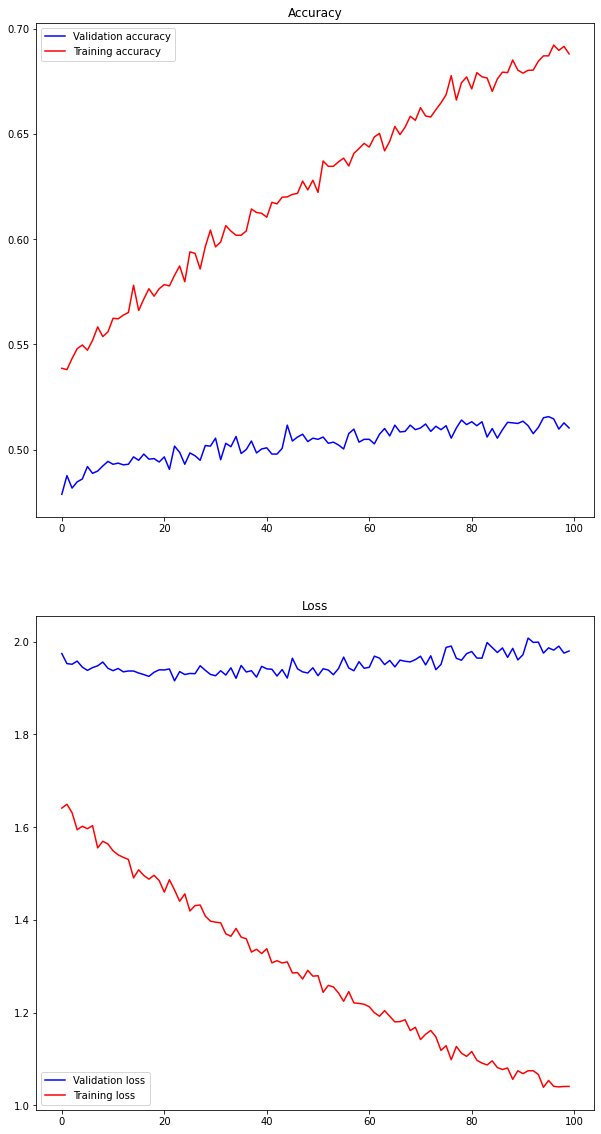

In [25]:
plot_training_curves(history_part2)

In [26]:
ds_train = get_training_dataset_preview(ordered=True)
ds_valid = get_validation_dataset(ordered=True)

x_train = ds_train.map(lambda image, label: image)
x_valid = ds_valid.map(lambda image, label: image)

train_preds = model.predict(x_train)
train_preds = np.argmax(train_preds, axis=-1)

valid_preds = model.predict(x_valid)
valid_preds = np.argmax(valid_preds, axis=-1)

y_train = ds_to_labels(ds_train, NUM_TRAINING_IMAGES)
y_valid = ds_to_labels(ds_valid, NUM_VALIDATION_IMAGES)

In [27]:
from sklearn.metrics import classification_report

print('VALIDATION SET REPORT:\n', classification_report(y_valid, valid_preds, target_names=CLASSES))
print('TRAINING SET REPORT:\n', classification_report(y_train, train_preds, target_names=CLASSES))

VALIDATION SET REPORT:
                            precision    recall  f1-score   support

            pink primrose       0.69      0.53      0.60        79
hard-leaved pocket orchid       0.80      0.57      0.67         7
         canterbury bells       0.00      0.00      0.00         6
                sweet pea       0.00      0.00      0.00         6
            wild geranium       0.59      0.70      0.64       205
               tiger lily       0.59      0.40      0.48        25
              moon orchid       0.67      0.40      0.50         5
         bird of paradise       0.83      0.77      0.80        31
                monkshood       0.45      0.56      0.50        25
            globe thistle       0.68      0.79      0.73        24
               snapdragon       0.19      0.12      0.15        40
              colt's foot       0.47      0.69      0.56        13
              king protea       0.70      0.52      0.60        27
            spear thistle       0.66 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


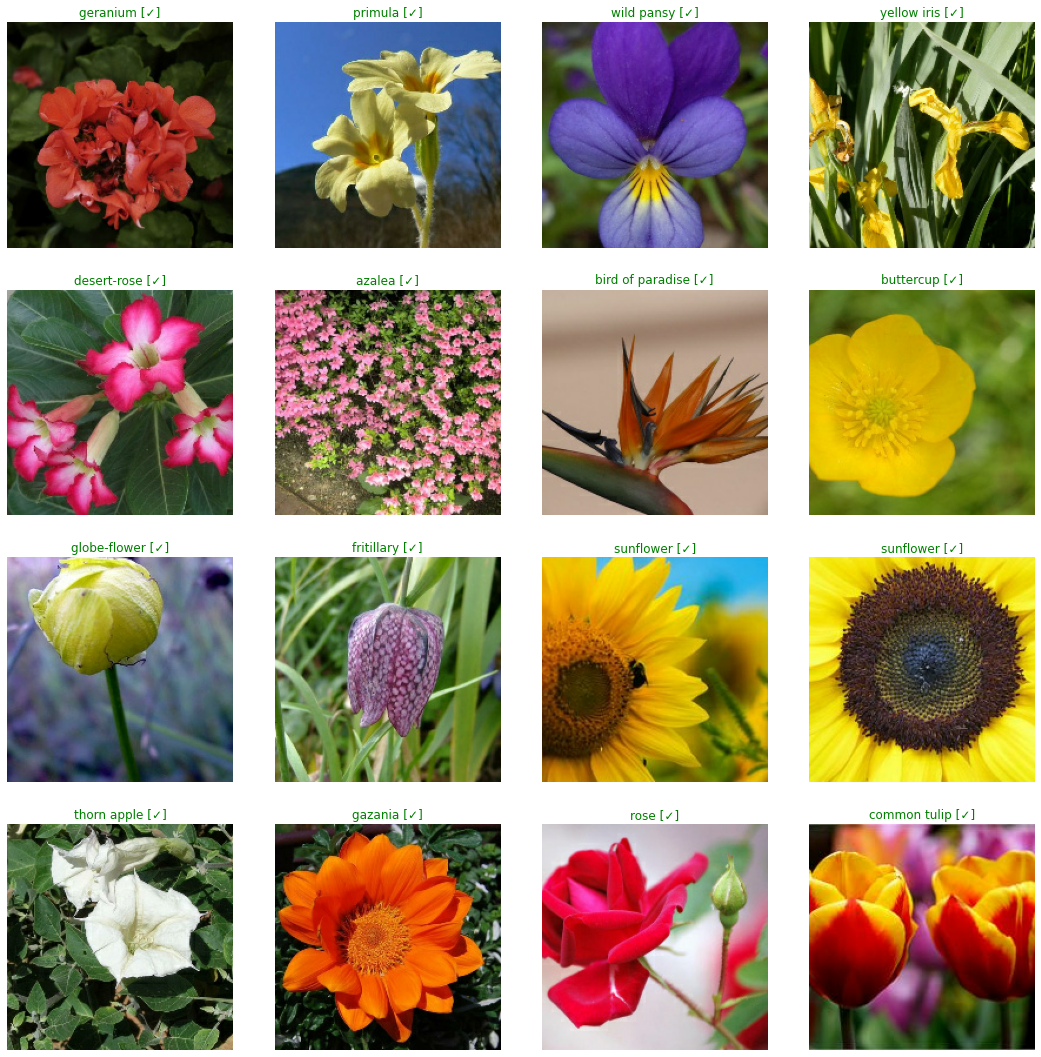

In [37]:
show_batch(ds_train, pred_model=model)

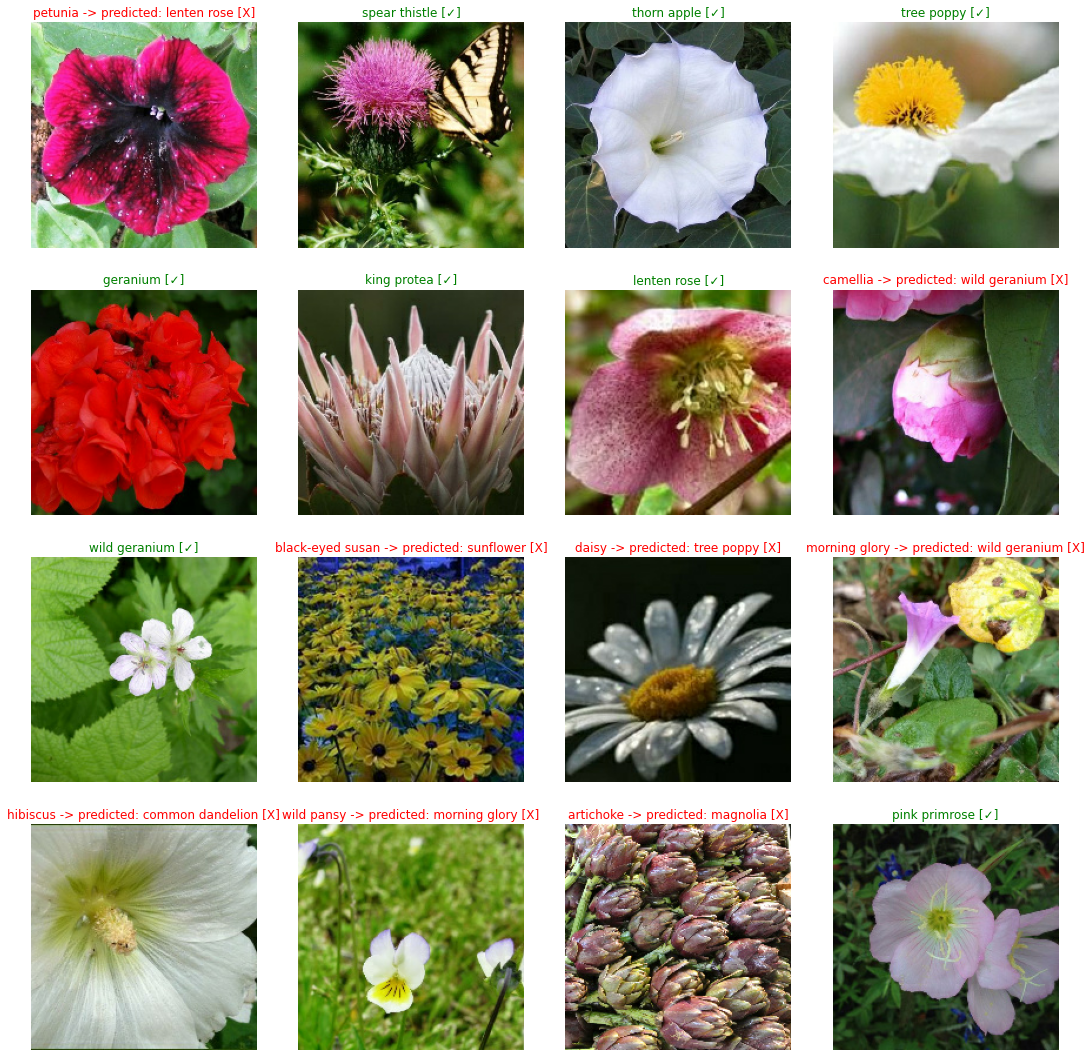

In [40]:
show_batch(ds_valid, pred_model=model)

In [41]:
ds_test = get_test_dataset(ordered=True)
ds_test_ims = ds_test.map(lambda image, idnum: image)
test_preds = model.predict(ds_test_ims)
test_preds = np.argmax(test_preds, axis=-1)

2022-06-11 06:16:22.476291: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 177914, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1654928182.475611103","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 177914, Output num: 0","grpc_status":3}


In [42]:
def show_batch(ds_test, test_preds, batch_size=16):
    images = next(iter(ds_test.unbatch().batch(batch_size))).numpy()
    preds = test_preds[:batch_size]
    
    ncols = math.floor((math.sqrt(len(preds))))
    nrows = len(preds) // ncols
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    fig.tight_layout()
    i = 0
    for ax, image, pred in zip(axs.flatten(), images, preds):
        ax.imshow(image)
        ax.set_title('Prediction: {}'.format(CLASSES[pred]))
        ax.axis('off')

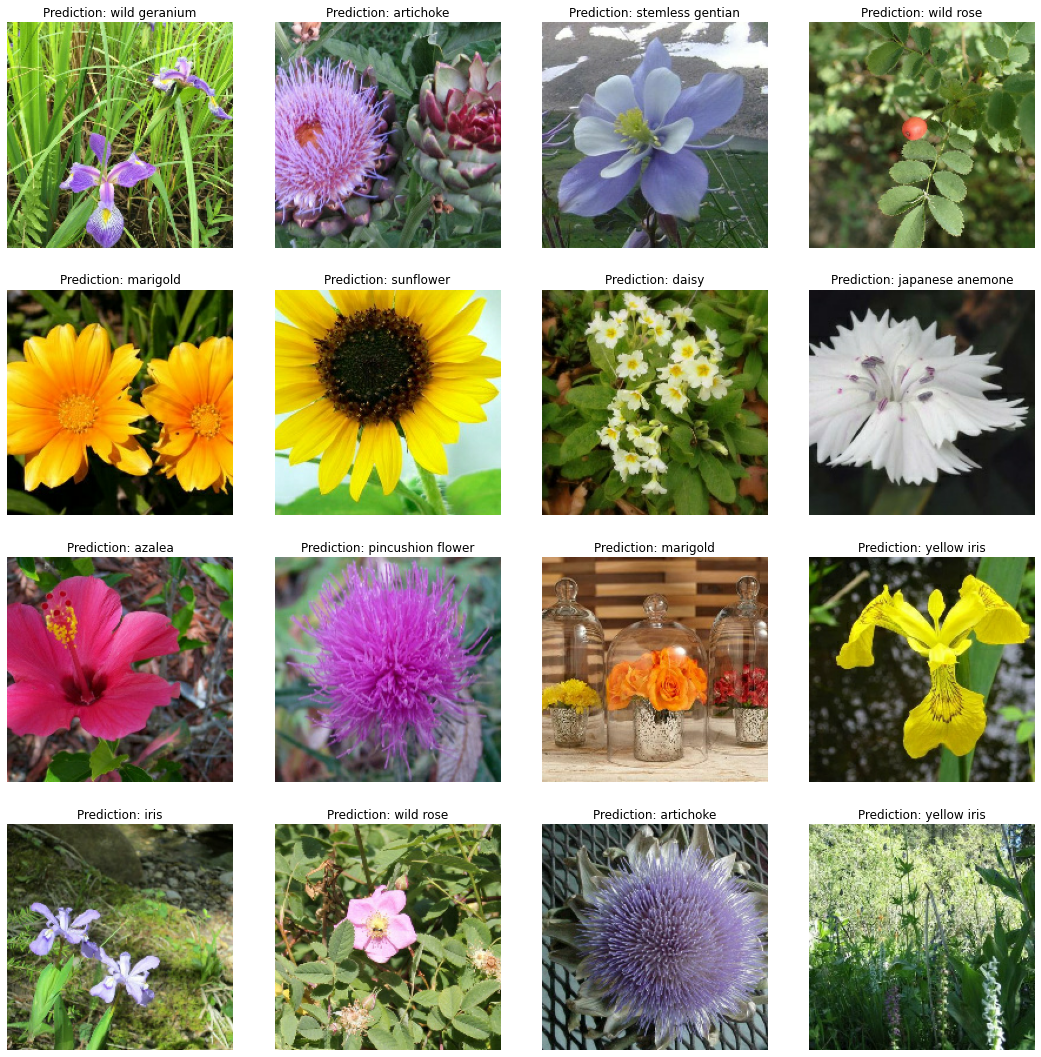

In [43]:
show_batch(ds_test_ims, test_preds)

In [44]:
ds_test_ids = ds_test.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(ds_test_ids.batch(NUM_TEST_IMAGES))).numpy().astype('U')

submission = pd.DataFrame(test_ids, columns=['id'])
submission['label'] = test_preds
submission.to_csv('submission.csv')
submission.head(10)

id  label
0  252d840db      4
1  1c4736dea     28
2  c37a6f3e9     27
3  00e4f514e    103
4  59d1b6146     46
5  8d808a07b     53
6  aeb67eefb     48
7  53cfc6586     61
8  aaa580243     71
9  d907ca7c0     21